In [1]:
# https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
# http://ling.snu.ac.kr/class/cl_under1801/EncoderDecoderLSTM.pdf

In [2]:
# 2022.01.03/ tf: 2.7.0, cuda: 11.2, cudnn: 11.x match
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import math

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tqdm import tqdm
import random
from keras.callbacks import History
from tensorflow.keras.optimizers import Adam



In [3]:
from keras import backend as K
K.clear_session()

In [4]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [5]:
seed_everything(42)

In [6]:
os.getcwd()

'c:\\Users\\simjh96\\myFarm\\learning'

In [7]:
# hyper param
learning_rate = 5e-4 # 학습률
BATCH_SIZE = 64 # 배치사이즈
EPOCHS = 100 # 총 eopochs
teacher_forcing = True # 교사강요 설정
n_layers = 1 # lstm 레이어 층
# dropout = 0.2 # 드롭아웃
window_size = 28 # 인코더 시퀀스 길이 == look back
future_size = 28 # 디코더 시퀀스 길이
hidden_dim = 1 # rnn 히든차원; 너무 크게 해서 dense의 weight 가 0. 나온걸수도
save_path = f'./models/s2s_0105' # 모델 저장 경로

In [8]:
enc_n, enc_t, enc_m = None, window_size, 1
dec_n, dec_t, dec_m = None, future_size, 1


In [9]:
def create_dataset(data: np.array, window_size: int = 1, future_size: int = 1):
    enc_inps, dec_inps, dec_tgts = [], [], []
    for i in range(len(data)-window_size-future_size):
        enc_inp = data[i:i+window_size, :]
        dec_inp = data[i+window_size-1:i+window_size+future_size-1, :]
        dec_tgt = data[i+window_size:i+window_size+future_size, :]

        enc_inps.append(enc_inp)
        dec_inps.append(dec_inp)
        dec_tgts.append(dec_tgt)

    enc_inps, dec_inps, dec_tgts = \
        np.array(enc_inps).astype('float32'), \
        np.array(dec_inps).astype('float32'), \
        np.array(dec_tgts).astype('float32')
    print(f"enc_inps.shape:{enc_inps.shape}")
    print(f"dec_inps.shape:{dec_inps.shape}")
    print(f"dec_tgts.shape:{dec_tgts.shape}")
    
    return enc_inps, dec_inps, dec_tgts


In [10]:
df = pd.read_csv(r'../data/top1.csv')
df = df.set_index('saleDate')
top1_arr = df.to_numpy().reshape([-1, 1]).astype("float32")
top1_arr.shape

(1220, 1)

In [11]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(top1_arr.reshape([-1,1]))
dataset.shape

(1220, 1)

In [12]:
# # split into train and test sets
# train_size = int(len(dataset) * 0.67)
# test_size = len(dataset) - train_size
# train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
# train.shape

In [13]:
# shape [samples, time steps, features]
enc_inps, dec_inps, dec_tgts = create_dataset(dataset, window_size, future_size)

enc_inps.shape:(1164, 28, 1)
dec_inps.shape:(1164, 28, 1)
dec_tgts.shape:(1164, 28, 1)


In [14]:
# 앞뒤로 같으면 잘 된것
print(enc_inps[0, -1, :])
print(dec_inps[0, 0:2, :])
print(dec_tgts[0, 0, :])

[0.3097527]
[[0.3097527 ]
 [0.31563988]]
[0.31563988]


In [127]:
K.clear_session()

In [128]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, enc_m))
# we need to save model, which means for unrolling we can not use gpu; (CudnnLSTM is depracated, LSTM use gpu also under certain condition)
encoder_lstm = keras.layers.LSTM(hidden_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [129]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, dec_m))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(
    hidden_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(
    decoder_inputs, initial_state=encoder_states)
# put lambda layer
scale = tf.constant(float(1))
decoder_scale_layer = tf.keras.layers.Lambda(lambda x: x * scale)
decoder_outputs = decoder_scale_layer(decoder_outputs)

# dense layer to make latent_dim -> dec_m
# decoder_dense = keras.layers.Dense(dec_m, activation="relu")
# decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [36]:
print(f'encoder_inputs: {encoder_inputs}')
# print(f'encoder_lstm: {encoder_lstm}')
print(f'encoder_outputs: {encoder_outputs}')
print(f'encoder_states: {encoder_states}')
print(f'decoder_inputs: {decoder_inputs}')
# print(f'decoder_lstm: {decoder_lstm}')
print(f'decoder_outputs: {decoder_outputs}')
print(f'enc_inps.shape: {enc_inps.shape}')
print(f'dec_inps.shape: {dec_inps.shape}')
print(f'dec_tgts.shape: {dec_tgts.shape}')

encoder_inputs: KerasTensor(type_spec=TensorSpec(shape=(None, None, 1), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'")
encoder_outputs: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='lstm_2/PartitionedCall:0', description="created by layer 'lstm_2'")
encoder_states: [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'lstm_2')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'lstm_2')>]
decoder_inputs: KerasTensor(type_spec=TensorSpec(shape=(None, None, 1), dtype=tf.float32, name='input_6'), name='input_6', description="created by layer 'input_6'")
decoder_outputs: KerasTensor(type_spec=TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None), name='lambda/mul:0', description="created by layer 'lambda'")
enc_inps.shape: (1164, 28, 1)
dec_inps.shape: (1164, 28, 1)
dec_tgts.shape: (1164, 28, 1)


In [37]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 1),          12          ['input_5[0][0]']                
                                 (None, 1),                                                       
                                 (None, 1)]                                                       
                                                                                            

In [134]:
# historys = {_:History() for _ in np.arange(1,11,2)}   # for param search
history = History()

In [135]:
initial_learning_rate = 0.1
decay_steps = 1.0
decay_rate = 0.5
learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate, decay_steps, decay_rate)


In [136]:
# for _ in np.arange(1, 11, 2):
model.compile(
    optimizer=Adam(learning_rate_fn), loss="mse", metrics=["mae"]
)
model.fit(
    [enc_inps, dec_inps],
    dec_tgts,
    batch_size=BATCH_SIZE,
    epochs=100,
    validation_split=0.2,
    callbacks=[history]
)
# # Save model
# model.save(f"s2s_lr")

Epoch 1/100
15/15 [==============================] - 3s 39ms/step - loss: 0.6810 - mae: 0.8135 - val_loss: 0.5422 - val_mae: 0.6805
Epoch 2/100
15/15 [==============================] - 0s 8ms/step - loss: 0.6810 - mae: 0.8135 - val_loss: 0.5422 - val_mae: 0.6805
Epoch 3/100
15/15 [==============================] - 0s 8ms/step - loss: 0.6810 - mae: 0.8135 - val_loss: 0.5422 - val_mae: 0.6805
Epoch 4/100
15/15 [==============================] - 2s 134ms/step - loss: 0.6810 - mae: 0.8135 - val_loss: 0.5422 - val_mae: 0.6805
Epoch 5/100
15/15 [==============================] - 0s 8ms/step - loss: 0.6810 - mae: 0.8135 - val_loss: 0.5422 - val_mae: 0.6805
Epoch 6/100
15/15 [==============================] - 0s 8ms/step - loss: 0.6810 - mae: 0.8135 - val_loss: 0.5422 - val_mae: 0.6805
Epoch 7/100
15/15 [==============================] - 0s 8ms/step - loss: 0.6810 - mae: 0.8135 - val_loss: 0.5422 - val_mae: 0.6805
Epoch 8/100
15/15 [==============================] - 0s 8ms/step - loss: 0.6810 

In [133]:
model.save(f"s2s_lr")

INFO:tensorflow:Assets written to: s2s_lr\assets


INFO:tensorflow:Assets written to: s2s_lr\assets


In [24]:
model.weights[0]
# <tf.Variable 'lstm_11/lstm_cell_11/kernel:0' shape=(1, 512) dtype=float32, numpy=
# array([[ 5.41475490e-02, -2.59233788e-02, -3.99200022e-02,


<tf.Variable 'lstm/lstm_cell/kernel:0' shape=(1, 4) dtype=float32, numpy=array([[6.029298, 4.32694 , 7.802438, 5.587532]], dtype=float32)>

In [25]:
model.weights[-1]
# <tf.Variable 'dense_3/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>
# target 값에 비해 output이 너무 작은듯
# lambda x: x*1000 해볼까...?
# relu 해볼까..

<tf.Variable 'lstm_1/lstm_cell_1/bias:0' shape=(4,) dtype=float32, numpy=array([-1.6676108, -5.8019915,  3.2779737, -1.6122926], dtype=float32)>

In [26]:
model.weights[-2]
# <tf.Variable 'dense_3/kernel:0' shape = (128, 1) dtype = float32, numpy =
# array([[-0.07640779],


<tf.Variable 'lstm_1/lstm_cell_1/recurrent_kernel:0' shape=(1, 4) dtype=float32, numpy=
array([[ 6.027891  ,  2.5952334 , -5.9992566 , -0.55087245]],
      dtype=float32)>

In [122]:
model = keras.models.load_model(f"s2s_lr")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

ValueError: Unable to create a Keras model from this SavedModel. This SavedModel was created with `tf.saved_model.save`, and lacks the Keras metadata.Please save your Keras model by calling `model.save`or `tf.keras.models.save_model`.

In [28]:
decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(hidden_dim,))
decoder_state_input_c = keras.Input(shape=(hidden_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
# decoder_dense = model.layers[4]
# decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)


In [29]:
states_value = encoder_model.predict(
    enc_inps[:1])   # enc_inps[:1].shape = (1, 28, 1), states_value[0].shape = (1, 128)
target_seq = np.zeros((1, 1, dec_m))
target_seq[0, 0, 0] = enc_inps[0,-1,0]

In [30]:
output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

In [31]:
output_tokens   # array([[[1.]]], dtype=float32)

array([[[0.31778774]]], dtype=float32)

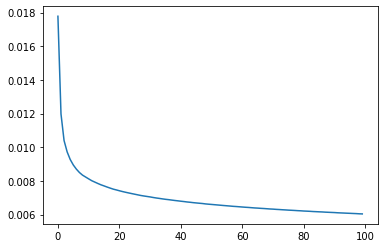

In [118]:
# learning rate 과 큰 상관 없음... 날씨 추가 하면 다를지도?

# 0.1/(1+step)
plt.plot(history.history['val_loss'])


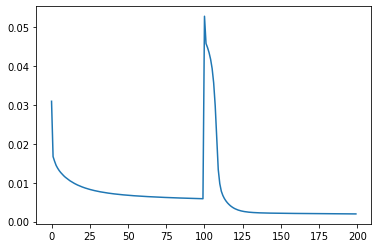

In [99]:
# learning rate 과 큰 상관 없음... 날씨 추가 하면 다를지도?

# 10/(1+step)
plt.plot(history.history['val_loss'])

In [ ]:
# full prediction for future 28

In [33]:
dec_prds = []
for _ in range(0,len(enc_inps),28):
    # dec_prd = []
    enc_inp = enc_inps[_:_+1]

    states_value = encoder_model.predict(
        enc_inp)   # enc_inps[:1].shape = (1, 28, 1), states_value[0].shape = (1, 128)
    target_seq = np.zeros((1, 1, dec_m))
    target_seq[0, 0, 0] = enc_inp[0,-1, 0]

    for i in range(future_size - 1):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        dec_prds.append(output_tokens[0,0,0])

        target_seq = np.zeros((1, 1, dec_m))
        target_seq[0, 0, 0] = output_tokens[0, 0, 0]
    # dec_prds.append(dec_prd)


KeyboardInterrupt: 

In [ ]:
enc_inps.shape

(1164, 28, 1)

In [ ]:
dec_prds = np.array(dec_prds)[...,np.newaxis]

In [ ]:
prds = scaler.inverse_transform(dec_prds)
front = list(scaler.inverse_transform(enc_inps[0]).reshape([-1]))
prds = front + list(prds.reshape([-1]))

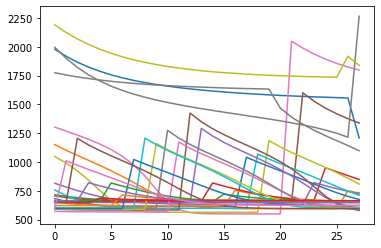

In [ ]:
# LSTM output default function이 relu 인듯.... dense(soft max 넣는게 좋을지도)
for h in range(1,30):
    plt.plot(prds[28*h:28+28*h])

In [ ]:
prds[28*h:28+28*h]

[2190.1135,
 2124.6165,
 2068.8716,
 2020.6697,
 1978.8718,
 1943.4039,
 1913.1713,
 1887.1016,
 1865.1824,
 1846.3672,
 1829.6118,
 1815.971,
 1803.3529,
 1792.8148,
 1783.3107,
 1775.9038,
 1769.5443,
 1763.1736,
 1757.8557,
 1753.5952,
 1749.3293,
 1746.1259,
 1742.9192,
 1740.244,
 1738.1025,
 1735.959,
 1917.9092,
 1838.8019]

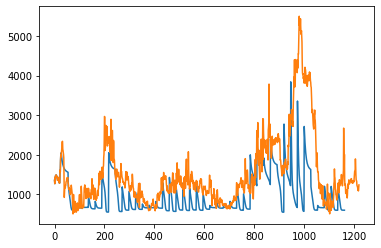

In [ ]:
plt.plot(prds)
plt.plot(top1_arr)